<a href="https://colab.research.google.com/github/0ethel0zhang/quantcon2022/blob/wip/ML_TLC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Coding exercise for [Representing Voices of Users at Scale, ML TLC for thematic coding](https://docs.google.com/presentation/d/13YIPU32a_HFGwlszvdMIVP9TSCd9GNoRYsviZanm-yc/edit?resourcekey=0-fdt0Kj8mVLrFdBNbRuxTLw#slide=id.g14d94fc545e_0_57) (code self link: go/ml_tlc).

You can follow along the quick 15-min walk-through video [here](https://www.google.com/url?q=https://drive.google.com/file/d/1mi9vxcRbpwtpV-XJ1ug68_8nnezurXoL/view?usp%3Dshare_link%26resourcekey%3D0-lMaxNmLZZLxHmZHRN4cf2A&sa=D&source=editors&ust=1675782918303743&usg=AOvVaw1yRLx1vglBZ2NrwUswLcpg).

# 0. Setup

**ATTENTION:** To use the Tensorflow Hub in this colab, you need to connect to the TF-enabled runtime. <br/>
If your local runtime doesn't support tensorflow, you can use a Brain Frameworks runtime. The details of running it can be found [here](https://docs.google.com/document/d/1sCvpCNXq4hOpDWKEcfC5rie0f7JTpqzwVhLKqiLlZZ8/edit).

## 0.1 Libraries

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tf.enable_v2_behavior()

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [5]:
from collections import Counter
import re
import string

import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk.data
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [43]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# 1. Acquire the data

##1.1 Download CLINC150

CLINC150 is a new dataset that includes queries with intents and queries that are out-of-scope (OOS), i.e., queries that do not fall into any of the system's supported intents.

The CLINC150 dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the CLINC150 dataset to your machine (or the colab runtime):

In [6]:
data = tfds.load(name = "clinc_oos", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/6 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/15000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/4500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-test.tfrecord*...:   0%|       …

Generating validation examples...:   0%|          | 0/3000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-validation.tfrecord*...:   0%| …

Generating train_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-train_oos.tfrecord*...:   0%|  …

Generating test_oos examples...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-test_oos.tfrecord*...:   0%|   …

Generating validation_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incomplete6VCP9J/clinc_oos-validation_oos.tfrecord*...:   …

Dataset clinc_oos downloaded and prepared to /root/tensorflow_datasets/clinc_oos/0.1.0. Subsequent calls will reuse this data.


In [7]:
sample_n = 500 #@param sample_n
text = [tfds.as_numpy(x["text"]) for x in data.take(sample_n)]
intent = [tfds.as_numpy(x["intent_name"]) for x in data.take(sample_n)]

## 1.2 Explore the data

In [8]:
print("Text entries: {}, intent entries: {}".format(len(text), len(intent)))

Text entries: 500, intent entries: 500


Let's look at some of the text.

In [9]:
text[-3:]

[b'on my shopping list , remove eggs',
 b'do you know any jokes',
 b'who is it that you work for']

# What's next? To build the model

Building a clustering model requires three main architectural decisions:

* How to represent the text?
* Which clustering model to use?

# 2. Transform the responses

## 2.1 Transform input into embeddings

In this example, the input data consists of sentences. As suggested by TensorFlow, "One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.
"


Here are many [embeddings models](https://www.tensorflow.org/text/guide/word_embeddings) from [TensorFlow Hub](https://www.tensorflow.org/hub) that you can try. This turorial will use the Universal Language Encoder i.e. **Option 1** in the following list of light-weight embeddings:

* [universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4) "*The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.*"
* [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2) - 50-dimension embedding trained on English Google News 7B corpus
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of  50.

In [10]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
kona2 = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [11]:
def plot_similarity(labels, features, rotation1, rotation2):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation1)
  g.set_yticklabels(labels, rotation=rotation2)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 0, 90)

## 2.2 Clean text

### Data Cleaning: This example follows the following data cleaning pipeline:
- Lower case
- Expand contractions
- Remove punctuations
- Word Tokenization
- POS tagging
- Lemmatization (you can also choose stemming)
- [Optional] Remove verbs
- Remove stop words


More details can be found in this [slide deck](https://docs.google.com/presentation/d/1WUflQdOTCr9SDWcyHKmXYPNmTZ2OvGiljicD5CS3gV8/edit#slide=id.ge7c4bcb690_0_0).

In [24]:
#@title Import NLTK library [CODE BLOCK]
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from nltk.tokenize import word_tokenize

# from nltk.corpus import libraries
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = WordNetLemmatizer()
print(wordnet_lemmatizer.lemmatize('dogs'))

dog


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [16]:
#@title Import personalized cleaning functions
class text_cleaning_helper():
  # The pipeline of text preprocessing does the following steps on each sentence
  #   1. Convert text to lowercase
  #   2. Expand contractions
  #   3. Remove punctuations while preserving google internal links (e.g. go/)
  #   4. Lemmatize with the option to keep certain POS only
  #   5. Remove stop words

  def __init__(self):
    self.status = True
    # compile all punctuations besides _ and / (for links)
    self.punc = string.punctuation.replace("_", "").replace("/", "")
    # create English stop words list (you can always define your own stopwords)
    self.stop_words = set(stopwords.words("english"))
    # add to stop words
    for x in [
        "ive", "could", "would", "also", "need", "want", "also", "though",
        "even", "etc", "within"
    ]:
      self.stop_words.add(x)
    self.wordnet_lemmatizer = WordNetLemmatizer()
    # set up [contractions](https://source.corp.google.com/piper///depot/google3/java/com/google/corp/culture/analytics/analysis/servlets/textnormalization/Contractions.java)
    self.contractions = {
      "he's": "he is",
      "i'll": "i will",
      "i've": "i have",
      "it'd": "it had",
      "it's": "it is",
      "so's": "so is",
      "we'd": "we had",
      "i'd": "i would",
      "i'm": "i am",
      "shouldn't've": "should not have",
      "couldn't've": "could not have",
      "mightn't've": "might not have",
      "oughtn't've": "ought not have",
      "wouldn't've": "would not have",
      "mustn't've": "must not have",
      "needn't've": "need not have",
      "there'd've": "there would have",
      "they'll've": "they will have",
      "what'll've": "what will have",
      "y'all'd've": "you all would have",
      "hadn't've": "had not have",
      "shan't've": "shall not have",
      "she'll've": "she will have",
      "should've": "should have",
      "shouldn't": "should not",
      "that'd've": "that would have",
      "they'd've": "they would have",
      "who'll've": "who will have",
      "you'll've": "you will have",
      "can't've": "cannot have",
      "could've": "could have",
      "couldn't": "could not",
      "he'll've": "he will have",
      "it'll've": "it will have",
      "might've": "might have",
      "mightn't": "might not",
      "oughtn't": "ought not",
      "she'd've": "she would have",
      "we'll've": "we will have",
      "where've": "where have",
      "won't've": "will not have",
      "would've": "would have",
      "wouldn't": "would not",
      "y'all're": "you all are",
      "y'all've": "you all have",
      "you'd've": "you would have",
      "doesn't": "does not",
      "haven't": "have not",
      "he'd've": "he would have",
      "how'd'y": "how do you",
      "i'll've": "i will have",
      "it'd've": "it would have",
      "must've": "must have",
      "mustn't": "must not",
      "needn't": "need not",
      "o'clock": "of the clock",
      "sha'n't": "shall not",
      "there'd": "there had",
      "there's": "there is",
      "they'll": "they will",
      "they're": "they are",
      "they've": "they have",
      "we'd've": "we would have",
      "weren't": "were not",
      "what'll": "what will",
      "what're": "what are",
      "what've": "what have",
      "when've": "when have",
      "where'd": "where did",
      "where's": "where is",
      "will've": "will have",
      "y'all'd": "you all would",
      "aren't": "are not",
      "'cause": "because",
      "didn't": "did not",
      "hadn't": "had not",
      "hasn't": "has not",
      "how'll": "how will",
      "i'd've": "i would have",
      "mayn't": "may not",
      "musn't": "must not",
      "shan't": "shall not",
      "she'll": "she will",
      "that'd": "that would",
      "that's": "that is",
      "they'd": "they would",
      "wasn't": "was not",
      "what's": "what is",
      "when's": "when is",
      "who'll": "who will",
      "who've": "who have",
      "why've": "why have",
      "y'alls": "you alls",
      "you'll": "you will",
      "you're": "you are",
      "you've": "you have",
      "ain't": "am not",
      "can't": "cannot",
      "don't": "do not",
      "he'll": "he will",
      "how'd": "how did",
      "how's": "how is",
      "isn't": "is not",
      "it'll": "it will",
      "let's": "let us",
      "ma'am": "madam",
      "she'd": "she would",
      "she's": "she is",
      "so've": "so have",
      "to've": "to have",
      "we'll": "we will",
      "we're": "we are",
      "we've": "we have",
      "who's": "who is",
      "why's": "why is",
      "won't": "will not",
      "y'all": "you all",
      "you'd": "you had",
      "he'd": "he would",
      "he's": "he is",
      "i'll": "i will",
      "i've": "i have",
      "it'd": "it had",
      "it's": "it is",
      "so's": "so is",
      "we'd": "we had",
      "i'd": "i would",
      "i'm": "i am"
    }

  def remove_multiple_spaces(self, word_string):
    """Remove multiple spaces and return string.

     Args:
       word_string: a str object of the text to be cleaned
     Returns:
       a cleaned string
    """
    found = re.findall("\s+", word_string)
    for f in set(found):
      word_string = word_string.replace(f, " ")
    return word_string

  def remove_multiple_underscores(self, word_string):
    """Remove multiple underscores and return string.

    Args:
      word_string: a str object of the text to be cleaned
    Returns:
      a cleaned string
    """
    found = re.findall("_{2,}", word_string)
    for f in set(found):
      word_string = word_string.replace(f, "_")
    return word_string

  def combined_processor(self, word_string):
    """Combine multiple text cleaning functions to one.

    Args:
      word_string: a str object of the text to be cleaned
    Returns:
      cleaned string.
    """
    return self.remove_multiple_spaces(
        self.remove_multiple_underscores(
            word_string.replace("\n", " ").replace("\t", " ").replace(
                "â", "'").replace("Â\xa0", "").replace("â", "").replace(
                    "Â", "").replace("as well as",
                                     "also").replace("stadia", "stadia_")))

  ### step-wise functions
  ### Step 1 - 3: lower case, expand contractions and remove punctuations ###
  def process_line(self, line):
    """Step 1. Convert text to lowercase.
    Step 2. expand contractions.
    Step 3. Remove punctuations while preserving google internal links (e.g. go/).

    Args:
      line: (str) a string of words in a sentence.
    Returns:
      lowercased sentence with no punctuations besides the ones in links.
    """

    if line is not None:
      # lower case
      temp = line.lower()
      # contractions
      for k, v in self.contractions.items():
        if k in temp:
          temp = temp.replace(k, v)
      # normalize go links into the same go link
      temp = temp.replace("go/ link", "go link")
      # remove punctuations
      temp = temp.translate(str.maketrans("", "", self.punc))
      return self.combined_processor(temp)
    else:
      return None

  ### Step 4 & 5: lemmatize with the option for pos-filtering & remove stopwords
  ###
  def clean(self, doc, lem=True, pos=False):
    # Function to remove stop words from sentences & lemmatize verbs and nouns
    if doc is not None:
      tokenized = word_tokenize(doc)
      if pos:
        cleaned = [
            w[0] for w in nltk.pos_tag(tokenized) if w[1][0] in ["J", "N", "R"]
        ]
        if lem:
          cleaned = [
              self.wordnet_lemmatizer.lemmatize(w[0],
                                                self.get_wordnet_pos(w[1]))
              for w in nltk.pos_tag(tokenized)
              if w[1][0] in ["J", "N", "R"]
          ]
      elif lem:
        cleaned = [
            self.wordnet_lemmatizer.lemmatize(w[0], self.get_wordnet_pos(w[1]))
            for w in nltk.pos_tag(tokenized)
        ]
      else:
        cleaned = tokenized
        del tokenized
      stop_free = [x for x in cleaned if x not in self.stop_words]
      return stop_free
    else:
      return None

  # get word positions
  def get_wordnet_pos(self, tag):
    """Convert POS tags from treebank's format.

    This represents the categories of words that will actually be affected by
    lemmatization.
    e.g. a noun like "wolves" --> "wolf" and a verb like "sharing" --> "share".

    Treebank:
      https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    Wordnet:
      http://www.nltk.org/book/ch05.html#a-universal-part-of-speech-tagset

    Args:
       tag: Treebank POS tag, e.g. "VBD" for "verb past tense"
    Returns:
       The corresponding Wordnet tag, e.g. wordnet.VERB. The default in noun.
    """
    if tag.startswith("J"):
      return wordnet.ADJ
    elif tag.startswith("V"):
      return wordnet.VERB
    elif tag.startswith("N"):
      return wordnet.NOUN
    elif tag.startswith("R"):
      return wordnet.ADV
    else:
      return wordnet.NOUN

  # flatten the list
  def flatten_list(self, lst):
    return [i for t in lst for i in t]

  # combines all
  def lines_to_topwords(self, intake, n=10, lem=True, pos=False):
    """ process lines and create outputs.
      one_line_words: lemmetized and optionally pos-filtered list of words
    """
    one_line_words = one_line.apply(lambda doc: self.flatten_list(
        [self.clean(self.process_line(x), lem, pos) for x in sent_tokenize(doc)]))
    return one_line_words

  ## Other functions
  def get_bigrams(self, words_lst, n=2):
    # Create n gram dictionary
    bigrams = [[g for g in ngrams(w, n)] for w in words_lst]
    bigram_dict = Counter(self.flatten_list(bigrams))
    return bigrams, bigram_dict

  def count_words(self, x, n=5):
    return Counter(
        [item for sublist in x if sublist is not None
         for item in sublist]).most_common(n)

  def display_top_n(self, df, col):
    n = len(df[col].values[0])
    for i in range(n):
      df["most_popular_{}".format(
          str(i + 1))] = df[col].apply(lambda x: x[i] if len(x) > i else "")

  def weighted_counter(self, L, c=None):
    if c is None:
      c = Counter()
    for k, v in L:
      c.update({k: v})
    return c


In [20]:
TestClass = text_cleaning_helper()

In [25]:
#@title text cleaning
cleaned_text = [" ".join(TestClass.clean(TestClass.process_line(x.decode("utf-8")))) for x in text]

In [26]:
cleaned_text[:3]

['know change insurance policy', 'provide point life', 'tire fill enough']

In [27]:
#@title transform to embeddings
embeddings = kona2(cleaned_text)

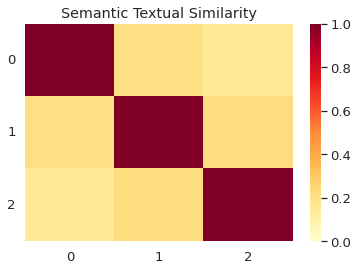

In [28]:
plot_similarity(range(3), embeddings[:3], 0, 0)

# 3. Cluster the responses

## 3.1 Build clustering model

Since text clusters are rarely of similar sizes and most of the time, we don't know the exact number of clusters there are, this tutorial focuses on clustering methodologies that deals with non-spherical data and do not require pre-determined number of clusters. Usually hierarchical clustering models are more suitable for these needs. One such model that we will cover in this tutorial is the AgglomerativeClustering model in sklearn.

In [29]:
def cluster_with_many_ways(embeddings, way = 'complete', nsm = "cosine", thres = .7):
  """now you have the option to safety experiment with other clustering methods"""

  if way in ["ward", "single", "average"]:
    nsm = "euclidean"
    print("""The input metric {0} is not compatible with method {1}.
    Updated metric to be euclidean.""".format(nsm, way))
  # proprietary of ethelszhang@google.com, default to consine distance
  linkage_df = sch.linkage(embeddings, method = way, metric = nsm)
  threshold = thres*max(linkage_df[:,2])
  ncluster = sum([x[2] > threshold for x in linkage_df]) + 1
  # create clusters
  hc = AgglomerativeClustering(
      n_clusters = ncluster, affinity = nsm, linkage = way)
  # save clusters for chart
  y_hc = hc.fit_predict(embeddings)
  return y_hc

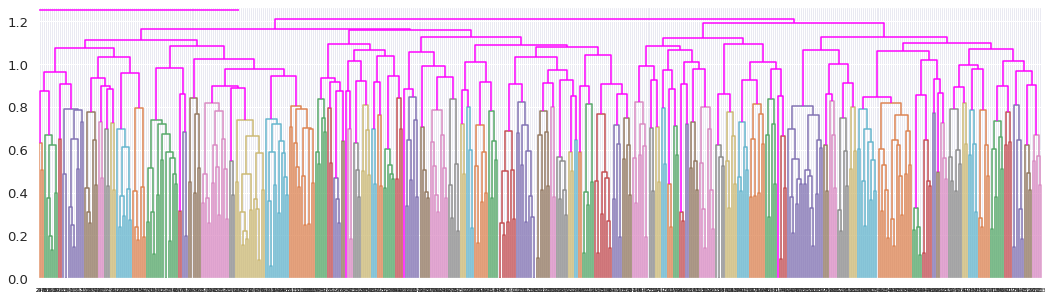

In [30]:
#@title Create dendrogram graph
plt.figure(figsize = (18, 5))
dendrogram = sch.dendrogram(
    sch.linkage(embeddings, method='complete', metric = "cosine"),
    leaf_rotation=0, above_threshold_color='magenta')
plt.hlines(1.25, 0, 1000, color = "magenta")

In [31]:
#@title get clusters
y_hc = cluster_with_many_ways(embeddings)

# compile output
output_df = pd.DataFrame([y_hc, text, intent]).T.rename(
    columns = dict(zip(range(3), ["cluster", "text", "intent"])))

In [32]:
# [OPTIONAL] to get lower-level branches
output_df["sub_cluster"] = cluster_with_many_ways(embeddings, thres=.6)
output_df.sub_cluster.nunique()

149

## 3.2 Explore output [Optional]

In [33]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

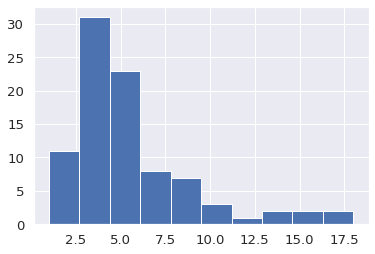

In [34]:
# distribution of cluster size
plt.hist(output_df.cluster.value_counts());

## 3.3 Summarize the clusters

In [35]:
#@title Get cluster centers (averages)
cluster_label_list = output_df.cluster.unique()
cluster_idx = output_df.reset_index().groupby("cluster")["index"].unique()

cluster_centers = {}
cluster_grouped = {}
for c in cluster_label_list:
  total_embeddings = [embeddings[i,:] for i in cluster_idx[c]]
  cluster_ctr = np.mean(total_embeddings, 0)
  cluster_centers[c] = cluster_ctr
  cluster_grouped[c] = total_embeddings

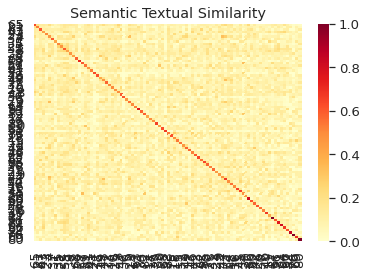

In [36]:
#@title plot cluster correlations
plot_similarity(
    list(cluster_centers.keys()), list(cluster_centers.values()), 90, 0)

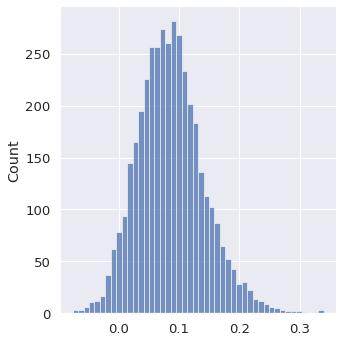

In [37]:
#@title histogram of cluster correlations
sns.displot(
  upper_tri_indexing(
    np.inner(list(cluster_centers.values()), list(cluster_centers.values()))
  )
)

# 4. Evaluate the clusters of text

In [38]:
def top_words(word_lst, n=3):
  try:
    return " * ".join([x[0] for x in Counter([w for g in word_lst for w in g]).most_common(n)])
  except:
    print("something wong")
    return ""

In [39]:
output_df["norm_text"] = cleaned_text
output_df["norm_word_lst"] = output_df["norm_text"].apply(lambda x: x.split(" "))

In [40]:
cluster_df = output_df.groupby("cluster").agg({
      "norm_text":lambda x: "".join(str(x)),
      "intent":lambda x: "".join(str(x)),
      "text":np.size,
      "norm_word_lst":top_words}
    ).sort_values("text", ascending = False).reset_index()

In [44]:
#@title invetigate how well clusters aligned with intents
data_table.DataTable(cluster_df.set_index("cluster"), num_rows_per_page=5)

,norm_text,intent,text,norm_word_lst
cluster,,,,
20,147 add milk shopping list\n168...,147 b'shopping_list_update'\n168 b'shopp...,18,list * shopping * add
4,6 step get reward visa...,6 b'redeem_rewards'\n13 b'transac...,17,card * credit * reward
38,17 clue taco bell take reservati...,17 b'accept_reservations'\n19 b'accept...,16,reservation * take * cancel
29,42 get credit limit increase 1000\...,42 b'credit_limit_change'\n52 ...,15,credit * score * limit
7,18 saving account interest\n2...,18 b'interest_rate'\n21 b'travel...,14,bank * account * interest
...,...,...,...,...
66,306 start use different accent\n461 pl...,306 b'change_accent'\n461 b'change_accen...,2,start * use * different
52,65 rent car 3 1 3 3 boston prefer suv\...,65 b'car_rental'\n275 b'book_hotel'\nNa...,2,3 * boston * may
76,411 breakfast place full morning\nName: nor...,"411 b'how_busy'\nName: intent, dtype: object",1,breakfast * place * full


## Write out